# Visual Odometry

In [51]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import sys 
import os
import skimage.io

In [2]:
# Load Camera Matrix 
K = np.loadtxt('K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [3]:
# Read the images with skimage 
im0 = skimage.io.imread('./sequence/000001.png')
im1 = skimage.io.imread('./sequence/000002.png')
im2 = skimage.io.imread('./sequence/000003.png')

In [4]:
# Read the images with CV2

im0 = cv2.imread("./sequence/000001.png", cv2.IMREAD_GRAYSCALE) 
im1 = cv2.imread("./sequence/000002.png", cv2.IMREAD_GRAYSCALE) 
im2 = cv2.imread("./sequence/000003.png", cv2.IMREAD_GRAYSCALE) 

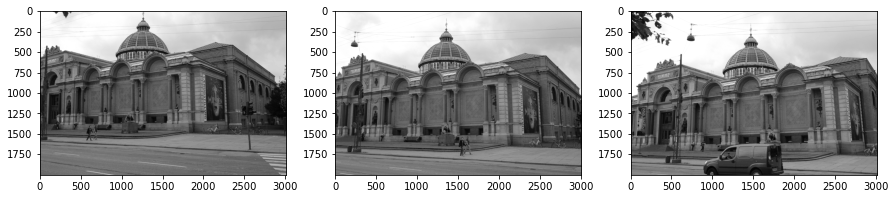

In [5]:
# Plot the Images 
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(im0, cmap= 'gray')
ax[1].imshow(im1, cmap= 'gray')
ax[2].imshow(im2, cmap= 'gray')

In [6]:
# Extract the SIFT matches of the three images 
# Initiate SIFT detector
sift = cv2.SIFT_create(nfeatures=2020)

# Find the keypoints and descriptors with SIFT
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# Convert the matches to numpy arrays
keypoints0 = np.array([k.pt for k in kp0])
keypoints1 = np.array([k.pt for k in kp1])
keypoints2 = np.array([k.pt for k in kp2])


# BFMatcher with default params, Find the keypoints 
# For each descriptor in the first set, this matcher finds the closest descriptor in
# the second set by trying each one. This descriptor matcher supports masking permissible 
# matches of descriptor sets.

# METHOD 1
# bf = cv2.BFMatcher(crossCheck=True)
# # Extract the matches between Image 0 and 1
# mat01 = bf.match(des0, des1)
# # Extract macthes between Image 1 and 2
# mat12 = bf.match(des1, des2)

# matches01 = np.array([(m.queryIdx, m.trainIdx) for m in mat01])
# matches12 = np.array([(m.queryIdx, m.trainIdx) for m in mat12])

# METHOD 2
bf = cv2.BFMatcher()
mat01 = bf.knnMatch(des0, des1, k = 2)
mat12 = bf.knnMatch(des1, des2, k = 2)

# Transform the matches into arrays 
matches01 = np.array([(m.queryIdx, m.trainIdx) for m,_ in mat01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m,_ in mat12])

In [49]:
keypoints0

array([[ 182.47413635,  620.199646  ],
       [2962.10986328,  860.61590576],
       [2962.10986328,  860.61590576],
       ...,
       [ 138.78994751,  503.58465576],
       [  94.81214142,  669.73919678],
       [1493.16540527,  391.83810425]])

### What are the matches?

A match object has dimensions (n,2). It basicallly tells you which key points from the image 1 has been matched with the key points from Image 2. 
When you are passing the descriptor from image 1 and 2 to get the matches, the first column of the matches tells you which key points from image 1 that have made a match with image 2. Consequently, the second columns tells you which keypoints from image 2 that have made match with image 1

In [8]:
print(keypoints0.shape, keypoints1.shape, keypoints2.shape)
print(matches01.shape, matches12.shape)

(2020, 2) (2020, 2) (2020, 2)
(2020, 2) (2020, 2)


In [9]:
# Estimate the esential matrix using RANSAC algorithm with the key points 
E_est, _ = cv2.findEssentialMat(keypoints0, keypoints1, cameraMatrix=K, method=cv2.RANSAC)

In [10]:
E_est

array([[-0.03649002,  0.70222192,  0.06979473],
       [-0.64046474, -0.00895499, -0.28225728],
       [-0.09317976,  0.02492529, -0.03785981]])

In [11]:
inliers, R1, t1, mask = cv2.recoverPose(E_est, keypoints0, keypoints1, K)

inliers -> the number of inliers which pass the cheirality check.

In [12]:
matches01.shape

(2020, 2)

In [13]:
matches01_inliers = matches01[mask[:, 0].astype(bool)]
matches01_inliers.shape

(729, 2)

In [14]:
idx = np.where(mask==255)
matches_01 = matches01[idx]
matches_01.shape

(729,)

### Check which points from image 0 are also in image 2 
In order to acomplish that we have to check the keypoints from image 0 that lay (or also are) in image 0. Then check the keypoints from image 2 that lay in image 1. Then once we have the points from image 0 and image 2 on the image 1, compare if the keypoints from both images are the same. 

In [15]:
_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)
# We are specifying that the image in comon is the image 1, as the matches01 are which keypoints from image 0 have been 
# matched with Image 1, and respectively, matches12, are which keypoints from image 1 have been matched with Image 2


In [16]:
intersection01 = matches01[idx01]
intersection12 = matches12[idx12]

In [17]:
points_im0 = keypoints0[intersection01[:,0]]
points_im1 = keypoints1[intersection01[:,1]]
points_im2 = keypoints2[intersection12[:,1]]

points_im0.shape, points_im0.shape, points_im0.shape

((1288, 2), (1288, 2), (1288, 2))

## Triangulation 

In [18]:
def projectMat(K, R, t):
    """
    Given the Camera Matrix, the Rotation Matrix and the translation vector. Creates the Projection Matrix.
    P = K*[R t]
    K-> Camera Matrix
    R-> Rotation Matrix
    t-> Translation vector
    
    P-> Projection Matrix.
    """
    
    if K.shape != (3,3):
        print('Check your Camera Matrix, it should have dimensions (3,3) and it has: ', K.shape)
    if R.shape != (3,3):
        print('Check your Rotatio Matrix, it should have dimensions (3,3) and it has: ', R.shape)
    if t.shape == (3,1):
        pass 
    else:
        t = squeezdim(t).reshape(-1,1)
    
    Rt = np.column_stack([R, t])
    P = K@Rt
    
    return P

In [19]:
# As we start out motion in image 000 we assume that that there's no translation and no rotation 
R0 = np.eye(3)
t0 = np.array([[0, 0, 0]]).T
P0 = projectMat(K, R0, t0)
P0

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03, 0.0000000e+00],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00]])

### Estimate the projection matrix P with the Rotation and Translation of the image 1 

In [20]:
P1 = projectMat(K, R1, t1)
print(type(P1))
print(P1)

<class 'numpy.ndarray'>
[[-3.43820903e+03 -3.88113278e+02 -5.05674664e+01  1.37062913e+03]
 [-6.39544067e+01 -3.26488583e+03  1.57617576e+02  5.32037141e+02]
 [-4.21286808e-01 -2.51302788e-01  8.71415133e-01  9.89204627e-01]]


#### Seems that the problem has to do with the projection Matrix from Image 1, as the pose of the camera it's not as it should had to be

In [93]:
p1 = np.array([[ 3.44992501e+03, -2.60876005e+02, -6.65691262e+01,-2.31612343e+02],
               [ 1.75040407e+02, -3.07507771e+03, -1.09620748e+03,-6.79698106e+02],
               [ 4.19895394e-01,  2.70484539e-02, -9.07169355e-01,-9.25430708e-01]])
p1

array([[ 3.44992501e+03, -2.60876005e+02, -6.65691262e+01,
        -2.31612343e+02],
       [ 1.75040407e+02, -3.07507771e+03, -1.09620748e+03,
        -6.79698106e+02],
       [ 4.19895394e-01,  2.70484539e-02, -9.07169355e-01,
        -9.25430708e-01]])

In [21]:
Ps = np.array([P0, P1])
Ps.shape

(2, 3, 4)

In [22]:
def hom(Q):
    """
    Function that given a 2d or 3d point or set of points it transforms into homogenous form. 
    
    ARGUMENTS
    ---------
    Q -> np.array where te points have to be in column vectors. (2,n) or (3,n)
    
    RETURNS
    -------
    Q_tmp -> np.array (2+1, n) or (3+1, n)
    """
    n = Q.shape[1]
    Q_tmp = np.vstack([Q, np.ones(n)])
    
    return Q_tmp

In [23]:
def inhom(Q):
    """
    Return Q in inhomogenous form 
    
    ARGUMENTS
    ---------
    Q-> It's a point or a set of points in homogenous form:
        2D : (3,n)
        3D : (4,n)
    
    RETURNS
    -------
    Q_tmp -> Set of points in inhomogenous form
        2D: (2,n)
        3D: (3,n)
    """
    Q = np.array(Q)
    s = Q[-1,:]
    
    Q_tmp = (Q/s)[:-1,:]
    
    return Q_tmp

In [24]:
points_im0_h = hom(points_im0.T)
points_im1_h = hom(points_im1.T)

In [25]:
qs = np.array([points_im0_h[:,0], points_im1_h[:,0]])
qs1 = np.array([points_im0_h[:,1], points_im1_h[:,1]])
qs

array([[1.28974841e+03, 4.97419464e+02, 1.00000000e+00],
       [1.39920850e+03, 6.28311707e+02, 1.00000000e+00]])

In [26]:
def squeezdim(v):
    """
    Function that squeezes a vetor into a the form (n,)
    v: vector of dimension n.     
    """
    try:
        m,n = v.shape
    except ValueError:
        return v
    if m>n: 
        v = np.squeeze(v, axis=1)
    else:
        v = np.squeeze(v, axis=0)
    return v

In [27]:
def matrix_B_triangulation(q, P):
    """
    Creates  B matrix for Triangulation. Follows the next equation:
        qh = P*Q
    Where qh is a 2D point in homoogenous form [sx, sy, s], P is the Projection Matrix and Q it's a 3D point in homogenous
    coordinates [X, Y, Z, 1].
    We can rearange it as:
        s * [x, y].T = [p(1)*Q, p(2)*Q].T
    Where p(i) = row vector of P. P(1) = P[0,:] (1,3) and the scale s = p(3)*Q:
        0 = [p(3)*x-p(1), p(3)*y-p(2)].T*Q
    
    PARAMETERS
    q: Point in homogenous fom [sx, sy, s] -> (3,1)
    P: projection matrix K*[R t] -> (3,4)
    RETURNS
    B: B Matrix (2,4)
    """

    q = squeezdim(q)
    
    if q.shape != (3,):
        print('q is not in Homogenous form: ', q.shape)
        return False
    # Transform into inhomogeous form [x, y, 1] in case it's not in homogenous form. 
    q = q/q[-1]
    
    
    #  Extract parameters 
    x = q[0]
    y = q[1]
    p_1 = squeezdim(P[0,:])
    p_2 = squeezdim(P[1,:])
    p_3 = squeezdim(P[2,:])
    # Create B
    B = np.array([(p_3*x - p_1), (p_3*y-p_2)])
    
    return B

In [29]:
def triangulate(qs:list, P:list):
    """
    Find points in 3D given a set of points in 2D and the Cameras' Projection Matrices used to obtain those 2D points.
    Using Linear algorithm.
    Create a Matrix B fof (n*2,4) where n is the number of cameras. Check Triabngulate_B for further doc.
    One We have B we apply singular value decomposition.
        arg min||B*Q||_2
    Wehere we impose the constrain of:
        ||Q||_2 = 1
    To specify that Q hasn't to be 0.
    
    PARAMETERS
    qs: List of points in 2D points in homogenous from. Scale Matters. 
    P: List of Projection Matrix.
    
    RETURNS
    Q: Estimated point in 3D in Homogenous coordinates [X, Y, Z, 1]
    """
    
    # Check The same samount of points and cameras.
    if len(qs) != len(P):
        print('Different number of 2D points and Projection matrix.')
        return False
    
    # Get the number of cameras
    n = len(P)
    # Set step for the B matrix 
    step = 2

    # Initializate B
    B = np.zeros((step*n, 4))
    
    for p,q,i in zip(P,qs, range(0,n*step,step)):
        B[i:i+step] = matrix_B_triangulation(q,p)

    _,s,eigVec = np.linalg.svd(B)
    # Find Min 
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    Q = eigVec[idx]
    
    return  Q

In [30]:
Q = triangulate(qs, Ps)
Q

array([[ 5.14777749e-04, -1.31213801e-02, -8.67389689e-03,
         9.99876156e-01]])

In [31]:
points_im0_h.shape

(3, 1288)

In [32]:
qs

array([[1.28974841e+03, 4.97419464e+02, 1.00000000e+00],
       [1.39920850e+03, 6.28311707e+02, 1.00000000e+00]])

### Once we can triangulate one point, we have to triangulate all the matches

In [33]:
def triangulate_multiple_points(Ps, *points):
    """
    Uses the function triangulate to iterate through all the 2d points and 
    
    ARGUMENTS
    ---------
    Ps -> Collection of projection matrices, can be in a list or in a 3d array [P0, P1, P2,...,Pn] or (n, P)
    points -> 2D points in homogenous from. (3, n)
    
    RETURNS
    -------
    Q -> np.array of the points in 3d in inhomogenous from (3,n)
    
    """
    points = np.array(points)
    
    # Check that the dimensions are the correct ones
    if points[0].shape[0] != 3:
        print('Points must be in homogenous form: (3,n)')
        return False
    
    # Initialize the vector Q for fast computation, set to homogenous form in 3D 
    Q = np.zeros((4,points[0].shape[1]))
    
    # Obtain the number of points that have been passed 
    n = points[0].shape[1]
    
    # Iterate through all the points 
    for i in range(n):
        # Select the same point from the different Images 
        qs = points[:,:,i]
        # Calculate the projection in 3d
        q_tmp = triangulate(qs, Ps)
        # Store the points 
        Q[:,i] = q_tmp
    
    # Convert the points into hoomogenous form 
    Q = inhom(Q)
    
    return Q

In [65]:
points3d = triangulate_multiple_points(Ps, points_im0_h, points_im1_h)

In [64]:
points3d.shape

(3, 1288)

In [55]:
def plot3d(*A, fsize:tuple=(15,15), lim: tuple= None):
    """
    A: Coordinate Matrix.
    fsize: figure size of the plot, by default (15,15)
    lim: limits of the plot, by default not set.
    Function to plot into a 3d space a matrix of coordinates.
    """
    
    
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(121, projection='3d')
    
    if lim:
        max, min = lim[0], lim[1]
        
        ax.set_xlim(min,max)
        ax.set_ylim(min,max)
        ax.set_zlim(min,max)
        
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    for e in A:
        e = np.array(e)
        ax.plot(e[0], e[1], e[2], 'o')

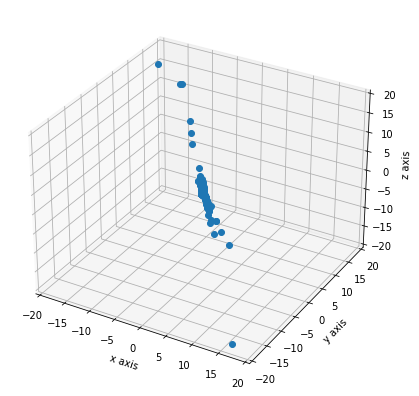

In [59]:
plot3d(points3d, lim=(20,-20))

### Now that we have the 3D points in the space, we can estimate the pose of the other cameras using the 3D points and the projection of these points in the camera x.
We can set the distorision coefficients to 5 as the lens have been already corrected. <br>
We'll estimate the pose of the camera 2.

In [36]:
points3d.shape, points_im2.shape

((3, 1288), (1288, 2))

In [37]:
_, rvec, tvec, inliers = cv2.solvePnPRansac(objectPoints=points3d.T, imagePoints=points_im2,
                                            cameraMatrix=K, distCoeffs=np.zeros(5))

In [38]:
inliers

array([[   7],
       [  17],
       [  34],
       [  49],
       [  52],
       [ 100],
       [ 103],
       [ 117],
       [ 140],
       [ 145],
       [ 149],
       [ 674],
       [ 676],
       [ 700],
       [ 713],
       [ 717],
       [ 718],
       [ 752],
       [ 760],
       [ 761],
       [ 773],
       [ 798],
       [ 801],
       [ 803],
       [ 808],
       [ 825],
       [ 872],
       [ 886],
       [ 897],
       [ 958],
       [ 959],
       [ 970],
       [ 986],
       [1015],
       [1045],
       [1225]], dtype=int32)

### What are the inliers, why we run RANSAC algorithm ? 
When we are computing the SIFT algorithm to detect matches between images it can happen that we get some mathces in the image that doesn't belong to the same 3d point, therefore they are not valid matches. As the SIFT algorithm detect how similiar are the points, it can happen that 2 points have the same local appearance, the same blobs but doesn't come from the same 3d point. We call these outliers. <br>

As we can't know which points are inliers or outliers we need to run RANSAC. In order to estimate the homography matrix we'll need 4 pair of matching points. Then, once we have computed the homography, we pass the matching points from one image to calculate where would lay in the image 2. 
In paralel, as we have the points in 3d, we we'll compute where the real points will lay in that image.
Finally, as we have the real projections and the projections of from th first image into the second one, we can compute the distance inbetween the the points. If the that distance is grater than a threshold it's considered an outlier, otherwise inlier.

In [39]:
Q = points3d.T
Q_tmp = Q[inliers.flatten()]
Q_tmp.shape

(36, 3)

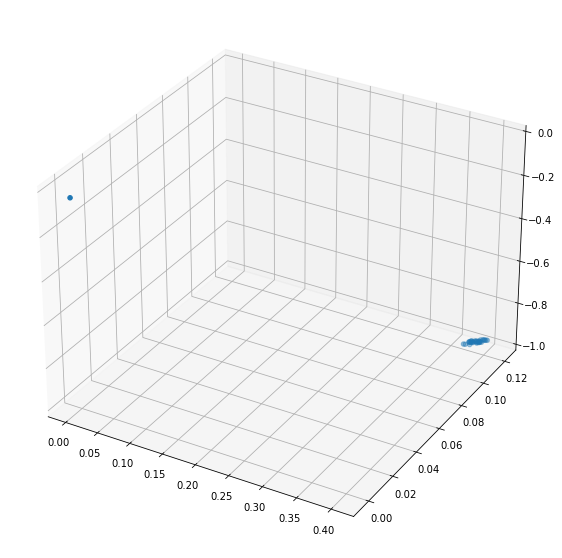

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(Q_tmp[:,0], Q_tmp[:,1], Q_tmp[:,2])

#### Why are plotting in 3D the inliers? 
Are we computing the 3d points from different images so that if they are close enough we have estimated a good Homography matrix?
